<a href="https://colab.research.google.com/github/anisetusms/DASI_DALIS_Kelompok_06/blob/main/dasi_dalis_kel_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Prediksi Peluang Obesitas pada Siswa SMA/SMK di Toba dan Tapanuli Utara Berdasarkan Pola Hidup Menggunakan Machine Learning
"""
# 1. IMPORT LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, classification_report, confusion_matrix,
                            roc_curve, roc_auc_score, auc)
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

print("Semua libraries berhasil dimuat!")

Semua libraries berhasil dimuat!


In [ ]:
# ==========================================
# 1. LOAD DATA
# ==========================================
print("\n" + "="*70)
print("TAHAP 1: PENGUMPULAN & LOADING DATA")
print("="*70)

df = pd.read_csv("data_siswa-siswi1.csv", sep=';', encoding='latin1')
print(f" Data berhasil dimuat: {df.shape[0]} baris, {df.shape[1]} kolom")

# Tampilkan semua kolom
print("\nDaftar Kolom:")
for i, col in enumerate(df.columns):
    print(f"  {i+1}. {col}")

# Drop kolom yang completely empty
df = df.dropna(axis=1, how="all")
print(f"\n Kolom kosong dihapus: Sisa {df.shape[1]} kolom")


TAHAP 1: PENGUMPULAN & LOADING DATA
 Data berhasil dimuat: 2050 baris, 27 kolom

Daftar Kolom:
  1. Timestamp
  2. Nama lengkap
  3. Jenis Kelamin
  4. Usia
  5. Jalur Pendidikan
  6. Asal Sekolah
  7. Kelas
  8.  Berapa berat badan kamu sekarang? (dalam kilogram)  
  9. Berapa tinggi badan kamu sekarang? (dalam centimeter)
  10. Dalam 7 hari terakhir, rata-rata kamu makan utama (pagi/siang/malam) berapa kali per hari? 
  11. Dalam 7 hari terakhir, kira-kira berapa kali kamu jajan (di luar makan utama)?  
  12. Dalam 7 hari terakhir, berapa kali kamu makan fast food / makanan cepat saji
  13. Dalam 7 hari terakhir, berapa gelas/porsi minuman manis (teh manis, minuman bersoda, boba, minuman serbuk manis) yang kamu konsumsi?
  14. Secara umum, jenis makanan apa yang paling sering kamu konsumsi?  
  15. Berapa kali kamu berolahraga dalam seminggu?
  16. Jika kamu berolahraga, rata-rata berapa menit durasi tiap kali olahraga?  
  17. Seberapa sering kamu dalam melakukan aktivitas fisik se

In [ ]:
# 2. DATA CLEANING & PREPROCESSING

print("TAHAP 2: PEMBERSIHAN & PREPROCESSING DATA (STANDARDIZED)")

# 2.1 Fungsi untuk membersihkan angka dengan satuan
def clean_numeric(val):
    """Membersihkan nilai numerik dengan satuan (kg, cm, tahun)"""
    if pd.isna(val):
        return np.nan
    val = str(val).lower()
    for unit in ["kg", "cm", "tahun", "th", "jam", "kilogram", "centimeter"]:
        val = val.replace(unit, "")
    val = val.replace(",", ".").strip()
    try:
        return float(val)
    except:
        return np.nan


TAHAP 2: PEMBERSIHAN & PREPROCESSING DATA (STANDARDIZED)


In [ ]:
# 2.2 Mapping kategori → nilai numerik (STANDARDIZED)
mapping_tidur = {"< 5 jam": 4, "5-6 jam": 5.5, "5–6 jam": 5.5, "7-8 jam": 7.5, "7–8 jam": 7.5, "> 8 jam": 9}
mapping_makan = {"1 kali": 1, "2 kali": 2, "3 kali": 3, "> 3 kali": 4}
mapping_jajan = {"0 - 2 kali": 1, "3 - 5 kali": 4, "4 - 5 kali": 4.5, "6 - 10 kali": 8, "> 10 kali": 12, "> 10  kali": 12}
mapping_fastfood = {"0 - 2 kali": 1, "3 -  5 kali": 4, "3 - 5 kali": 4, "> 5 kali": 7}
mapping_minuman = {"0 - 2 gelas": 1, "3 - 5 gelas": 4, "6 - 10 gelas": 8, "10 - 6 gelas": 8, "10 gelas": 8, ">10 gelas": 12, "> 10 gelas": 12}

mapping_makan_malam = {
    "0 Kali": 0,
    "0 kali": 0,
    "1 Kali": 1,
    "1 kali": 1,
    "2 - 3 kali": 2.5,
    "2 - 3 Kali": 2.5,
    "4 kali": 4,
    "5 Kali": 5,
    "> 4 kali": 6,
}

In [ ]:
# 2.3 Bersihkan kolom numerik dasar
df["berat_kg"] = df[" Berapa berat badan kamu sekarang? (dalam kilogram)  "].apply(clean_numeric)
df["tinggi_cm"] = df["Berapa tinggi badan kamu sekarang? (dalam centimeter)"].apply(clean_numeric)
df["usia_tahun"] = df["Usia"].apply(clean_numeric)
print(" Kolom numerik (berat, tinggi, usia) dibersihkan")


 Kolom numerik (berat, tinggi, usia) dibersihkan


In [ ]:
# 2.4 Mapping kategori frekuensi makan/minum
df["durasi_tidur_jam"] = (df["Rata-rata, berapa jam kamu tidur setiap malam?  "]
                          .astype(str).str.strip()
                          .str.replace(r'[-—\x96]', '–', regex=True)
                          .str.replace(r'\s*–\s*', '–', regex=True)
                          .str.replace(r'\s+', ' ', regex=True)
                          .replace(mapping_tidur).astype(float))
df["makan_per_hari"] = (df["Dalam 7 hari terakhir, rata-rata kamu makan utama (pagi/siang/malam) berapa kali per hari? "]
                        .astype(str).str.strip().replace(mapping_makan).astype(float))
df["jajan_per_minggu"] = (df["Dalam 7 hari terakhir, kira-kira berapa kali kamu jajan (di luar makan utama)?  "]
                          .astype(str).str.strip().str.replace(r'\s+', ' ', regex=True)
                          .replace(mapping_jajan).astype(float))
df["fastfood_per_minggu"] = (df["Dalam 7 hari terakhir, berapa kali kamu makan fast food / makanan cepat saji"]
                             .astype(str).str.strip().replace(mapping_fastfood).astype(float))
df["minuman_manis_per_minggu"] = (df["Dalam 7 hari terakhir, berapa gelas/porsi minuman manis (teh manis, minuman bersoda, boba, minuman serbuk manis) yang kamu konsumsi?"]
                                  .astype(str).str.strip().str.replace('> 10 gelas', '>10 gelas', regex=False)
                                  .replace(mapping_minuman).astype(float))
print("Mapping kategori frekuensi makan/minum selesai")

col_makan_malam = "Dalam 7 hari terakhir, berapa kali Anda mengonsumsi makanan utama atau cemilan setelah pukul 21.00? "
if col_makan_malam in df.columns:
    df["makan_setelah_21"] = (df[col_makan_malam]
                              .astype(str).str.strip()
                              .replace(mapping_makan_malam).astype(float))
    print(f"makan_setelah_21 - berhasil diproses")
    print(f"  Distribusi: {df['makan_setelah_21'].value_counts().to_dict()}")
else:
    # Coba cari kolom dengan nama mirip
    for col in df.columns:
        if "setelah pukul 21" in col.lower() or "setelah jam 21" in col.lower():
            df["makan_setelah_21"] = (df[col]
                                      .astype(str).str.strip()
                                      .replace(mapping_makan_malam).astype(float))
            print(f" makan_setelah_21 - berhasil diproses dari kolom: {col[:50]}...")
            break
    else:
        df["makan_setelah_21"] = np.nan
        print("makan_setelah_21 - kolom tidak ditemukan, diisi NaN")

col_aktivitas_new = "Seberapa sering kamu dalam melakukan aktivitas fisik sehari-hari (jalan kaki, naik & turun tangga, kegiatan di rumah/sekolah)?"
if col_aktivitas_new in df.columns:
    df["aktivitas_fisik_harian_new"] = pd.to_numeric(df[col_aktivitas_new], errors='coerce')
    print(f"aktivitas_fisik_harian_new - berhasil diproses")
    print(f"  Distribusi: {df['aktivitas_fisik_harian_new'].value_counts().to_dict()}")
else:
    for col in df.columns:
        if "naik & turun tangga" in col.lower():
            df["aktivitas_fisik_harian_new"] = pd.to_numeric(df[col], errors='coerce')
            print(f"aktivitas_fisik_harian_new - berhasil diproses dari kolom: {col[:50]}...")
            break
    else:
        df["aktivitas_fisik_harian_new"] = np.nan
        print("aktivitas_fisik_harian_new - kolom tidak ditemukan, diisi NaN")

col_makan_stres = "Dalam 7 hari terakhir, seberapa sering Anda mengonsumsi makanan akibat perasaan stres?  "
if col_makan_stres in df.columns:
    df["makan_karena_stres"] = pd.to_numeric(df[col_makan_stres], errors='coerce')
    print(f"makan_karena_stres - berhasil diproses")
    print(f"  Distribusi: {df['makan_karena_stres'].value_counts().to_dict()}")
else:
    # Coba cari kolom dengan nama mirip
    for col in df.columns:
        if "makanan akibat perasaan stres" in col.lower() or "makan akibat stres" in col.lower():
            df["makan_karena_stres"] = pd.to_numeric(df[col], errors='coerce')
            print(f"makan_karena_stres - berhasil diproses dari kolom: {col[:50]}...")
            break
    else:
        df["makan_karena_stres"] = np.nan
        print(" makan_karena_stres - kolom tidak ditemukan, diisi NaN")

Mapping kategori frekuensi makan/minum selesai
makan_setelah_21 - berhasil diproses
  Distribusi: {1.0: 791, 0.0: 545, 2.5: 539, 6.0: 130, 4.0: 25, 5.0: 20}
aktivitas_fisik_harian_new - berhasil diproses
  Distribusi: {4: 756, 5: 488, 3: 472, 2: 281, 1: 53}
makan_karena_stres - berhasil diproses
  Distribusi: {2: 610, 1: 565, 3: 468, 4: 265, 5: 142}


In [ ]:

# 2.5 Handle outlier BMI & tinggi badan SEBELUM imputasi
df['tinggi_meter'] = df['tinggi_cm'] / 100
df['BMI'] = df['berat_kg'] / (df['tinggi_meter'] ** 2)

df.loc[df['BMI'] > 50, 'BMI'] = np.nan  # BMI > 50 unrealistic untuk siswa
mask_potential_meters = (df["tinggi_cm"] >= 1.0) & (df["tinggi_cm"] <= 2.5)
df.loc[mask_potential_meters, "tinggi_cm"] *= 100
df.loc[(df["tinggi_cm"] < 100) | (df["tinggi_cm"] > 200), "tinggi_cm"] = np.nan
print("Outlier dihapus/disesuaikan")


Outlier dihapus/disesuaikan


In [ ]:
# 2.6 STANDARDIZED Imputasi MEDIAN untuk kolom numerik
imputer = SimpleImputer(strategy='median')
kolom_imputasi = [
    'berat_kg', 'tinggi_cm', 'usia_tahun', 'durasi_tidur_jam',
    'makan_per_hari', 'jajan_per_minggu', 'fastfood_per_minggu',
    'minuman_manis_per_minggu',
    'makan_setelah_21', 'aktivitas_fisik_harian_new', 'makan_karena_stres'
]

for kolom in kolom_imputasi:
    if kolom in df.columns:
        df[kolom] = imputer.fit_transform(df[[kolom]])[:, 0]

# Hitung ulang tinggi meter dan BMI setelah imputasi
df['tinggi_meter'] = df['tinggi_cm'] / 100
df['BMI'] = df['berat_kg'] / (df['tinggi_meter'] ** 2)

# Imputasi BMI dengan median
imputer_bmi = SimpleImputer(strategy='median')
df['BMI'] = imputer_bmi.fit_transform(df[['BMI']])[:, 0]

print("Median imputasi untuk kolom numerik selesai")



Median imputasi untuk kolom numerik selesai


In [ ]:
# 3. FEATURE ENGINEERING & ENCODING

print("TAHAP 3: FEATURE ENGINEERING & ENCODING (STANDARDIZED)")

# 3.1 Kategorisasi BMI
def bmi_category(bmi):
    """Kategorisasi BMI berdasarkan standar WHO"""
    if bmi < 18.5:
        return "Kurus"
    elif 18.5 <= bmi < 25:
        return "Normal"
    elif 25 <= bmi < 30:
        return "Overweight"
    else:
        return "Obesitas"

df["kategori_BMI"] = df["BMI"].apply(bmi_category)
df["label_obesitas"] = df["kategori_BMI"].apply(lambda x: 1 if x == "Obesitas" else 0)
print("Kategorisasi BMI & label obesitas dibuat")
print(f"  Class distribution: {df['label_obesitas'].value_counts().to_dict()}")


TAHAP 3: FEATURE ENGINEERING & ENCODING (STANDARDIZED)
Kategorisasi BMI & label obesitas dibuat
  Class distribution: {0: 1998, 1: 52}


In [ ]:
# 3.2 Encoding kolom kategorikal STANDARDIZED

df["keluarga_obesitas"] = df["Apakah ada keluarga Anda yang pernah atau sedang mengalami obesitas?"].apply(
    lambda x: 1 if str(x).strip().lower() == "iya" else 0)
df["jenis_kelamin"] = df["Jenis Kelamin"].apply(
    lambda x: 1 if str(x).strip().lower() == "laki-laki" else 0)
print("Encoding keluarga obesitas & jenis kelamin selesai")


Encoding keluarga obesitas & jenis kelamin selesai


In [ ]:
# 3.3 Rename kolom panjang (kolom lama - untuk backward compatibility)
df.rename(columns={
    "Seberapa sering kamu dalam melakukan aktivitas fisik sehari-hari (jalan kaki, naik turun tangga, kegiatan di rumah/sekolah)?  ": "aktivitas_fisik",
    "Seberapa sering kamu merasa stres (karena tugas, sekolah, keluarga, dsb)?  ": "tingkat_stres",
    "Seberapa besar pengaruh teman terhadap kebiasaan kamu jajan/makan (misalnya diajak nongkrong, makan bersama)?  ": "pengaruh_teman"
}, inplace=True)
print("Nama kolom diperpendek")


Nama kolom diperpendek


In [ ]:
# 3.4 Simpan dataset bersih

df.to_csv("dataset_bersih_final.csv", index=False)
print("Dataset bersih disimpan ke: dataset_bersih_final.csv")


Dataset bersih disimpan ke: dataset_bersih_final.csv



TAHAP 4: EXPLORATORY DATA ANALYSIS (EDA)

STATISTIK DESKRIPTIF:
        usia_tahun     berat_kg    tinggi_cm          BMI  makan_per_hari  \
count  2050.000000  2050.000000  2050.000000  2050.000000     2050.000000   
mean     16.152195    53.875566   159.174380    21.251282        2.813659   
std       0.955454    11.004193     8.142077     3.945066        0.550441   
min      14.000000    22.000000   115.000000     8.579027        1.000000   
25%      15.000000    48.000000   154.000000    19.051974        3.000000   
50%      16.000000    52.000000   159.000000    20.700817        3.000000   
75%      17.000000    58.000000   165.000000    22.656250        3.000000   
max      19.000000   167.000000   190.000000    61.839393        4.000000   

       jajan_per_minggu  minuman_manis_per_minggu  durasi_tidur_jam  \
count       2050.000000               2050.000000       2050.000000   
mean           3.976341                  2.565854          6.723171   
std            2.910584     

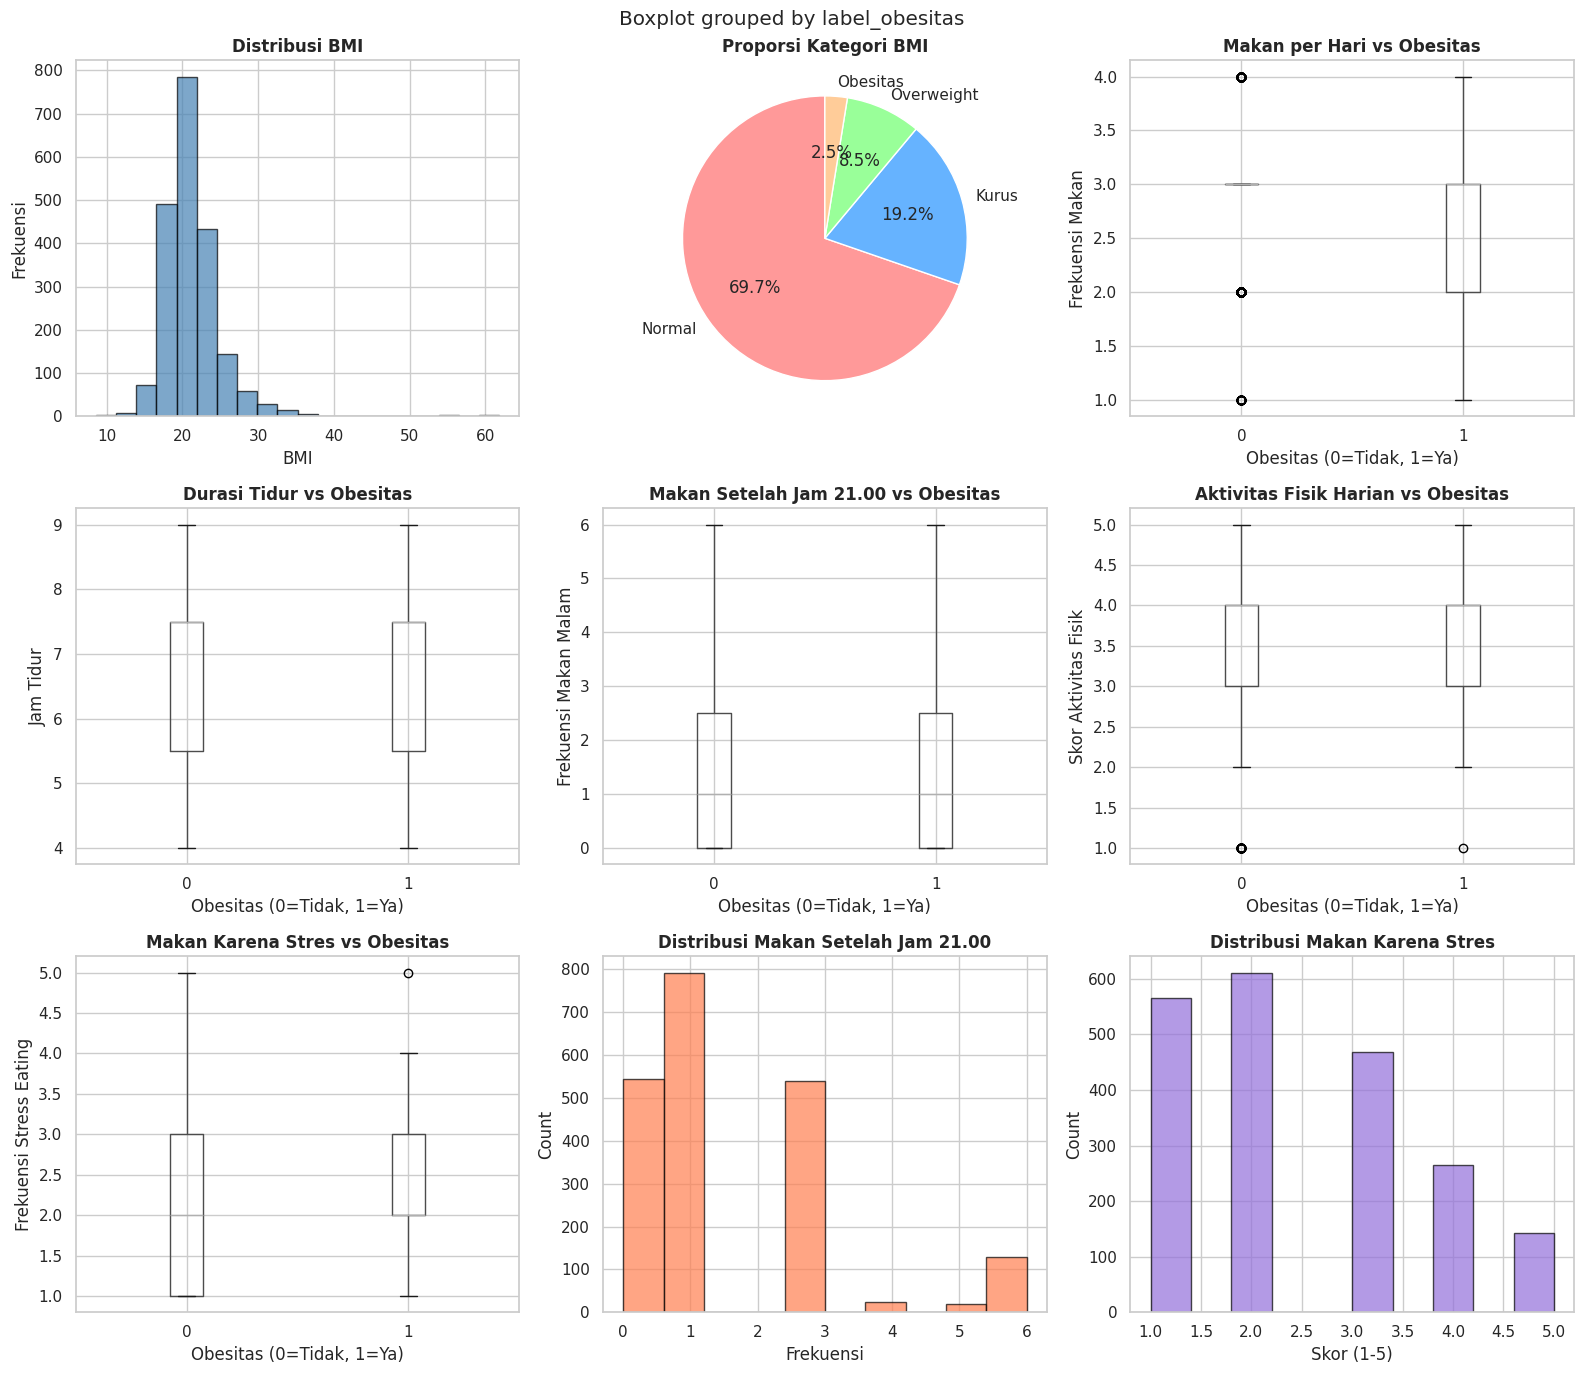

✓ Visualisasi EDA disimpan: eda_overview_v2.png


In [ ]:
# ==========================================
# 4. EXPLORATORY DATA ANALYSIS (EDA)
# ==========================================
print("\n" + "="*70)
print("TAHAP 4: EXPLORATORY DATA ANALYSIS (EDA)")
print("="*70)

print("\nSTATISTIK DESKRIPTIF:")
desc_cols = ['usia_tahun', 'berat_kg', 'tinggi_cm', 'BMI', 'makan_per_hari',
             'jajan_per_minggu', 'minuman_manis_per_minggu', 'durasi_tidur_jam',
             'makan_setelah_21', 'aktivitas_fisik_harian_new', 'makan_karena_stres']
print(df[[c for c in desc_cols if c in df.columns]].describe())

# Visualisasi
fig, axes = plt.subplots(3, 3, figsize=(16, 14))
fig.suptitle("Exploratory Data Analysis - Distribusi Utama & Fitur Baru", fontsize=16, fontweight='bold')

# Row 1
axes[0,0].hist(df["BMI"], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
axes[0,0].set_title("Distribusi BMI", fontweight='bold')
axes[0,0].set_xlabel("BMI")
axes[0,0].set_ylabel("Frekuensi")

bmi_counts = df["kategori_BMI"].value_counts()
axes[0,1].pie(bmi_counts, labels=bmi_counts.index, autopct='%1.1f%%', startangle=90,
              colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
axes[0,1].set_title("Proporsi Kategori BMI", fontweight='bold')

df.boxplot(column='makan_per_hari', by='label_obesitas', ax=axes[0,2])
axes[0,2].set_title("Makan per Hari vs Obesitas", fontweight='bold')
axes[0,2].set_xlabel("Obesitas (0=Tidak, 1=Ya)")
axes[0,2].set_ylabel("Frekuensi Makan")

# Row 2
df.boxplot(column='durasi_tidur_jam', by='label_obesitas', ax=axes[1,0])
axes[1,0].set_title("Durasi Tidur vs Obesitas", fontweight='bold')
axes[1,0].set_xlabel("Obesitas (0=Tidak, 1=Ya)")
axes[1,0].set_ylabel("Jam Tidur")

if 'makan_setelah_21' in df.columns:
    df.boxplot(column='makan_setelah_21', by='label_obesitas', ax=axes[1,1])
    axes[1,1].set_title("Makan Setelah Jam 21.00 vs Obesitas", fontweight='bold')
    axes[1,1].set_xlabel("Obesitas (0=Tidak, 1=Ya)")
    axes[1,1].set_ylabel("Frekuensi Makan Malam")

if 'aktivitas_fisik_harian_new' in df.columns:
    df.boxplot(column='aktivitas_fisik_harian_new', by='label_obesitas', ax=axes[1,2])
    axes[1,2].set_title("Aktivitas Fisik Harian vs Obesitas", fontweight='bold')
    axes[1,2].set_xlabel("Obesitas (0=Tidak, 1=Ya)")
    axes[1,2].set_ylabel("Skor Aktivitas Fisik")

# Row 3
if 'makan_karena_stres' in df.columns:
    df.boxplot(column='makan_karena_stres', by='label_obesitas', ax=axes[2,0])
    axes[2,0].set_title("Makan Karena Stres vs Obesitas", fontweight='bold')
    axes[2,0].set_xlabel("Obesitas (0=Tidak, 1=Ya)")
    axes[2,0].set_ylabel("Frekuensi Stress Eating")

# Distribusi 3 fitur baru
if 'makan_setelah_21' in df.columns:
    axes[2,1].hist(df['makan_setelah_21'].dropna(), bins=10, color='coral', edgecolor='black', alpha=0.7)
    axes[2,1].set_title("Distribusi Makan Setelah Jam 21.00", fontweight='bold')
    axes[2,1].set_xlabel("Frekuensi")
    axes[2,1].set_ylabel("Count")

if 'makan_karena_stres' in df.columns:
    axes[2,2].hist(df['makan_karena_stres'].dropna(), bins=10, color='mediumpurple', edgecolor='black', alpha=0.7)
    axes[2,2].set_title("Distribusi Makan Karena Stres", fontweight='bold')
    axes[2,2].set_xlabel("Skor (1-5)")
    axes[2,2].set_ylabel("Count")

# Korelasi dengan BMI
print("\n" + "-"*60)
print("KORELASI DENGAN BMI:")
print("-"*60)
numeric_df = df.select_dtypes(include=[np.number])
corr_bmi = numeric_df.corr()["BMI"].sort_values(ascending=False)
print(corr_bmi.head(10))

plt.tight_layout()
plt.savefig("eda_overview_v2.png", dpi=300, bbox_inches='tight')
plt.show()
print("✓ Visualisasi EDA disimpan: eda_overview_v2.png")